In [1]:
from kth_dataset import KTH_Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from LSTMscratch import LSTMscratch_GRU
import torch
import torch.nn as nn
from Model_Wrapper import Wrapper
import helper 


In [2]:
# Create a dataset and a DataLoader
transforms1 = {'val':transforms.Compose([
    transforms.Resize([32, 32]),  # Resize the image first
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
]),
'train':transforms.Compose([
    transforms.Resize([32, 32]),  # Resize the image first
    # transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
])
}



# Initialize dataset
test_dataset = KTH_Dataset(root_dir="/home/nfs/inf6/data/datasets/kth_actions/processed", sequence_length=20,split="test", transform=transforms1["val"],use_saved_samples=False)
train_dataset = KTH_Dataset(root_dir="/home/nfs/inf6/data/datasets/kth_actions/processed", sequence_length=20,split="train", transform=transforms1["train"],use_saved_samples=False)


In [3]:
train_dataset.__len__()

179911

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,num_workers=8,pin_memory=True)
print("test_dataset per epoch",next(iter(test_loader))[0].size())

test_dataset per epoch torch.Size([128, 20, 1, 32, 32])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
classes = ["Boxing","HandClapping","HandWaving","Jogging","Running","Walking"]


# LSTM scratch

  0%|          | 0/5623 [00:00<?, ?it/s]

Epoch 1 Iter 5623: loss 0.98456.: 100%|██████████| 5623/5623 [07:15<00:00, 12.91it/s]

Accuracy/train 32.31645560629145
Loss/train 1.2696657704645558


Accuracy/test 39.278021620742905
Loss/test 1.2865074562352097


Epoch 2 Iter 5623: loss 0.62158.: 100%|██████████| 5623/5623 [07:14<00:00, 12.94it/s]

Accuracy/train 50.83004296553425
Loss/train 0.9233534333970058


Accuracy/test 40.99406648784849
Loss/test 1.6728989728453953


Epoch 3 Iter 5623: loss 0.70062.: 100%|██████████| 5623/5623 [07:15<00:00, 12.92it/s]

Accuracy/train 57.74354397630522
Loss/train 0.7723797063227122


Accuracy/test 48.79805738437779
Loss/test 1.6245171476064082


Epoch 4 Iter 5623: loss 0.65135.: 100%|██████████| 5623/5623 [07:20<00:00, 12.76it/s]

Accuracy/train 69.67478701507348
Loss/train 0.5896033504568723


Accuracy/test 50.851418353247176
Loss/test 1.7755644416360443


Epoch 5 Iter 5623: loss 0.74497.: 100%|██████████| 5623/5623 [07:19<00:00, 12.81it/s]

Accuracy/train 76.24487396853313
Loss/train 0.47672027177219606


Accuracy/test 53.0287328293912
Loss/test 1.863193716092824


Epoch 6 Iter 5623: loss 0.69104.: 100%|██████████| 5623/5623 [07:17<00:00, 12.85it/s]

Accuracy/train 79.08741379516337
Loss/train 0.42009183862774097


Accuracy/test 53.2867999674876
Loss/test 1.965598208531159


Epoch 7 Iter 5623: loss 0.27223.: 100%|██████████| 5623/5623 [08:05<00:00, 11.57it/s]

Accuracy/train 80.87414536531219
Loss/train 0.3830614429382631


Accuracy/test 52.627407949280666
Loss/test 1.8350382326613315


Epoch 8 Iter 5623: loss 0.53910.: 100%|██████████| 5623/5623 [07:33<00:00, 12.39it/s]

Accuracy/train 82.12214109765512
Loss/train 0.35780634819168056


Accuracy/test 53.644436316345605
Loss/test 1.8420525744490353


Epoch 9 Iter 5623: loss 0.26140.: 100%|██████████| 5623/5623 [07:19<00:00, 12.79it/s]

Accuracy/train 83.56127816556122
Loss/train 0.3331865538504599


Accuracy/test 55.254815898561326
Loss/test 1.9312920842492263


Epoch 10 Iter 5623: loss 0.10514.: 100%|██████████| 5623/5623 [07:17<00:00, 12.87it/s]

Accuracy/train 84.84520582451584
Loss/train 0.3104887687758992


Accuracy/test 52.79809802487198
Loss/test 2.083398250236303
Validation accuracy: 52.8%


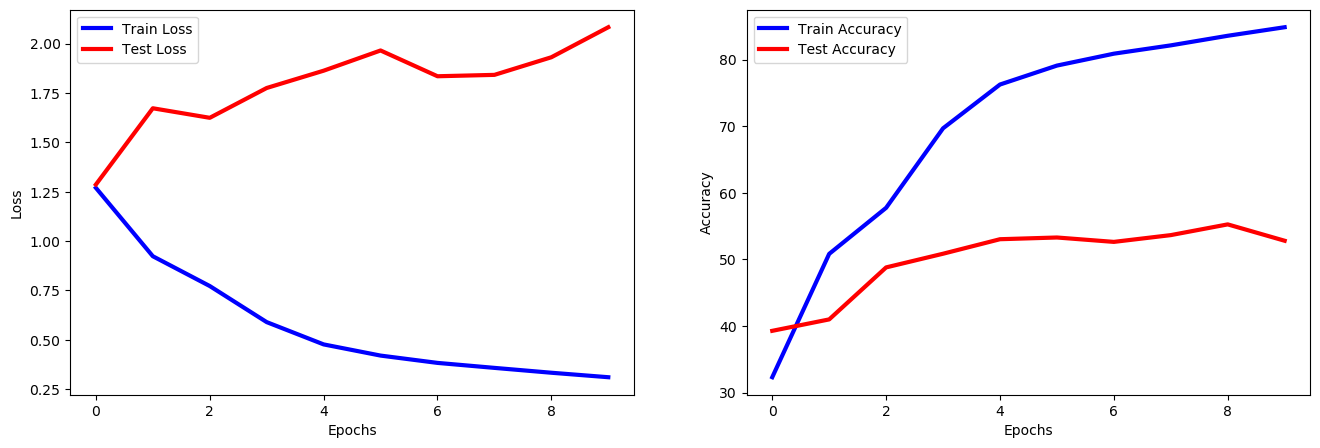

In [8]:
writer = helper.new_writer("models","LSTMscratch")
model = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=3,device=device,dropout=0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMscratch", model = model, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


# LSTM using nn.lstmcell

In [ ]:
writer = helper.new_writer("models","LSTM")
model_1 = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=2,device=device,use_custom=False,dropout = 0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMcell", model = model_1, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


  0%|          | 0/1406 [00:00<?, ?it/s]

Epoch 1 Iter 1406: loss 1.07036.: 100%|██████████| 1406/1406 [06:26<00:00,  3.64it/s]

Accuracy/train 29.60067342040108
Loss/train 1.3389764801197677


Accuracy/test 38.135007721693896
Loss/test 1.6691018549921608


Epoch 2 Iter 1406: loss 0.90775.: 100%|██████████| 1406/1406 [06:28<00:00,  3.62it/s]

Accuracy/train 50.92198847001642
Loss/train 0.9459958154056354


Accuracy/test 40.45049987807852
Loss/test 1.842761604805684


Epoch 3 Iter 1406: loss 0.85156.: 100%|██████████| 1406/1406 [06:30<00:00,  3.60it/s]

Accuracy/train 54.87945148565911
Loss/train 0.8653290349338336


# CONV LSTM 

In [ ]:
from ConvLSTMscratch import ConvLSTM

model = ConvLSTM(input_dim=1, hidden_dim=4, kernel_size=3, num_layers=2,batch_first=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
classes = ["Boxing","HandClapping","HandWaving","Jogging","Running","Walking"]
writer = helper.new_writer("models","ConvLSTMscratch")
train = Wrapper(model_name="ConvLSTM", model = model, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()


<img src="/home/user/elwakeely1/Cuda_Vision_Lab-/Session4/solution/Convlstmmodel.png" alt="Convlstmmodel" style="width:1000px;">


# 3D_ResNet 

In [ ]:
import torchvision.models as models

model = models.video.r3d_18(pretrained=True).to(device)

# Modify the final layer to match the number of classes to 6 for KTH Actions
model.fc = nn.Linear(model.fc.in_features, 6)

print(model)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

writer = helper.new_writer("models","3D_ResNet")
train = Wrapper(model_name="3D_ResNet", model = model_1, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)

train.train(10,train_loader,test_loader,classes)

writer.close()

train.valid_accuracy()
train.plot_loss_acc()


/home/user/elwakeely1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/elwakeely1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /home/user/elwakeely1/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 68.7MB/s] 


NameError: name 'device' is not defined

# GRU model 

  0%|          | 0/1406 [00:00<?, ?it/s]

Epoch 1 Iter 1406: loss 1.10109.: 100%|██████████| 1406/1406 [06:28<00:00,  3.62it/s]

Accuracy/train 31.51749738933777
Loss/train 1.302529420486385


Accuracy/test 36.559172559538325
Loss/test 1.5490565256195044


Epoch 2 Iter 1406: loss 0.79821.: 100%|██████████| 1406/1406 [06:24<00:00,  3.65it/s]

Accuracy/train 48.94475017388344
Loss/train 0.9812750389447084


Accuracy/test 39.17743639762659
Loss/test 1.9793148316123241


Epoch 3 Iter 1406: loss 0.84274.: 100%|██████████| 1406/1406 [06:22<00:00,  3.68it/s]

Accuracy/train 53.5032555262667
Loss/train 0.8952387437372764


Accuracy/test 40.4291636186296
Loss/test 2.0892716262475024


Epoch 4 Iter 1406: loss 0.97571.: 100%|██████████| 1406/1406 [06:27<00:00,  3.63it/s]

Accuracy/train 56.38359394850831
Loss/train 0.8539268709348242


Accuracy/test 42.323010647809475
Loss/test 1.9039866055406736


Epoch 5 Iter 1406: loss 0.81789.: 100%|██████████| 1406/1406 [06:23<00:00,  3.66it/s]

Accuracy/train 58.67783218410412
Loss/train 0.804993092717012


Accuracy/test 43.55136958465415
Loss/test 1.6024039154230425


Epoch 6 Iter 1406: loss 0.68688.: 100%|██████████| 1406/1406 [06:31<00:00,  3.60it/s]

Accuracy/train 61.9816158527233
Loss/train 0.7559569154999843


Accuracy/test 43.17646102576607
Loss/test 1.7178009694284107


Epoch 7 Iter 1406: loss 0.89267.: 100%|██████████| 1406/1406 [06:24<00:00,  3.66it/s]

Accuracy/train 64.37784634635831
Loss/train 0.7127517814698973


Accuracy/test 42.65118263838088
Loss/test 1.998464850845846


Epoch 8 Iter 1406: loss 0.62979.: 100%|██████████| 1406/1406 [06:22<00:00,  3.68it/s]

Accuracy/train 65.61453655787858
Loss/train 0.6834788647179583


Accuracy/test 42.863529220515325
Loss/test 1.9924827644342018


Epoch 9 Iter 1406: loss 0.64910.: 100%|██████████| 1406/1406 [06:29<00:00,  3.61it/s]

Accuracy/train 67.42835553209738
Loss/train 0.6584079983520983


Accuracy/test 45.234902056409005
Loss/test 1.7162757274904057


Epoch 10 Iter 1406: loss 0.68681.: 100%|██████████| 1406/1406 [06:25<00:00,  3.65it/s]

Accuracy/train 68.72067286191405
Loss/train 0.6373766664929614


Accuracy/test 44.40786799967488
Loss/test 1.9434200766245724
Validation accuracy: 44.41%


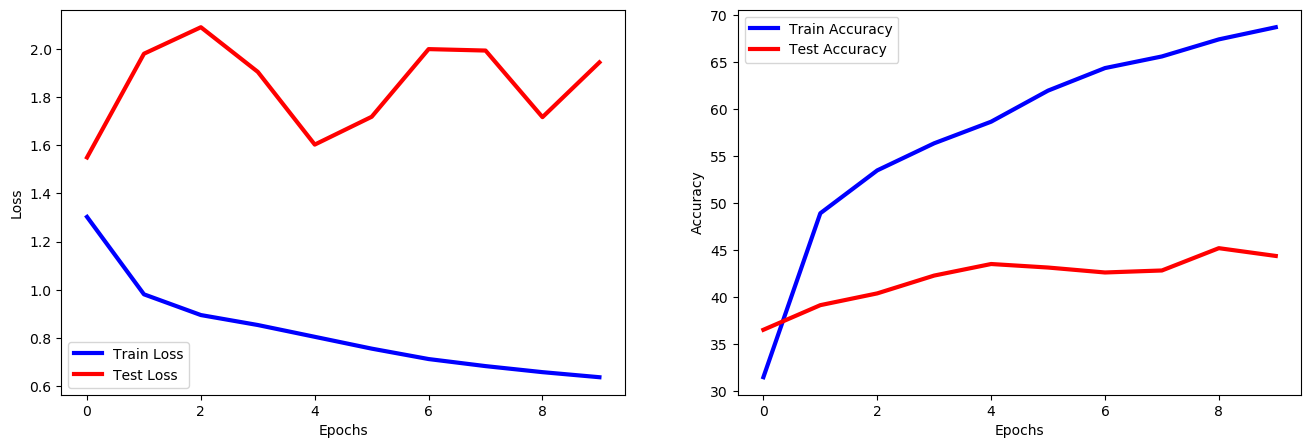

In [12]:
writer = helper.new_writer("models","GRU")
model_1 = LSTMscratch_GRU(input_dim=64, hidden_dim=16, number_of_layers=2,device=device,GRU=True,dropout=0.5).to(device)

# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train = Wrapper(model_name="LSTMcell", model = model_1, device = device, criterion = criterion, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader,classes)
writer.close()
train.valid_accuracy()
train.plot_loss_acc()

The ConvLSTM achieved the best results on the KTH Action Dataset because it combines convolutional layers with LSTM mechanisms. The convolutional layers are excellent for extracting spatial features (like textures and shapes in video frames), while the LSTMs handle temporal patterns, such as motion across frames. This combination makes ConvLSTMs especially effective for action recognition, where understanding both appearance and movement is crucial.

In contrast:

-GRU performed well but didn't capture spatial patterns as effectively because it lacks built-in convolutional layers.
-The standard LSTM also struggled with spatial information, as it’s not designed to process structured data like images -directly.

ConvLSTM's ability to process both spatial and temporal information makes it more suited for tasks involving motion analysis.